In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



# ============== MODELS
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier, \
GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC



# ============ METRICS & UTILS
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PolynomialFeatures
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer, \
f1_score, accuracy_score, log_loss
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# ============ AUXILIARY FUNCTIONS - func.py, voting_cv.py
from func import calc_prediction_success, fit_predict_report, confusion_matrix_scorer, best_metric, \
convert_cv_results, convert_boost_cv_results, best_boost_metric
# from voting_cv import VotingClassifierCV

# ============ Set random state
rnd = np.random.seed(7)

In [3]:
RandomForestClassifier()

RandomForestClassifier()

* *the notebook executes for around 8 minutes on a mediocre laptop*

# Beat the odds

## ... or how to beat the bad guys in their own game

Probably there's no single sports-betting fan knowing some machine learning "magic" who has never thought the bookmakers could be beaten at their own game. Good life, prosperity, fulfilled dreams are awaiting on the horizon, you just have to reach. One little algorithm will do the things for you...

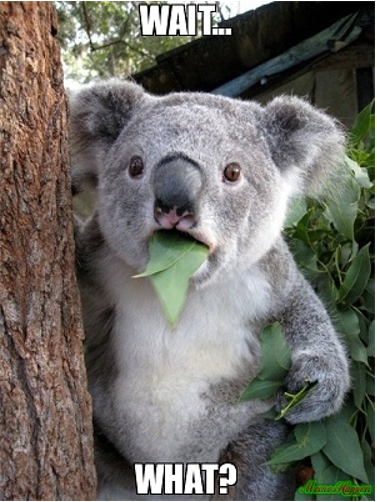

First of all - yes, your guess is correct, this study is about predicting sports matches outcome. More precisely football matches from good old England and their glorious "English Premier League" - for short EPL.  

Sports matches are considered "games of chance" hence unpredictable. Furthermore football is rumored more and more corrupted and the possibility of fixed matches is increasing. With that said let's try our luck or ...

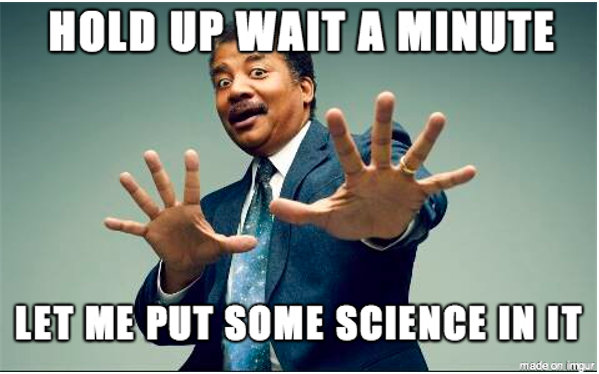

### How bets work

A footbal game has three possible outcomes - home win, draw and away(guest) win a.k.a. 1X2, so if one tries to predict a match purely on luck the chance is 33.3 %. But that's in case both teams are equaly good - that is usualy never met. Also the home team has an advantage in most cases because they play on home soil. These and other factors are taken into account when determining the probabilities of a particular outcome to occur. The probabilities determines the odds. The odds are defined as the probability that the event will occur divided by the probability that the event will not occur.


If the probability of an event occurring is Y, then the probability of the event not occurring is 1-Y. O is the odd the event to occur. This could be expressed as follows:


$$ O = \frac{Y}{1-Y}$$


if the probability of the event occurring = 0.80, then the odds are:

$$O = \frac{0.80}{1-0.80} =  4 $$


I.e. 4 to 1. You bet(give) 4 coins and if the event occur bookmaker gives you 5 and you have one coin profit, if not your 4 coins poorer. These are fractional odds and they're different to comprehend for people who are using the metric system of units.  
If we represent this 4 to 1 as 1 devided by 4 we get 1.25. Now if we multiply the imaganery 4 coins by 1.25 the result is 5. Exactly the same profit of 1 coin. Odds came in sevral form - fractional, decimal and US odds (moneyline odds), but they always represent the same thing - a probability some outcome to occur.

### Goal

No, not goal in the some footbal match, our goal. Our main focus is to predict winning team in every match in EPL. This will be a classification problem.

### Data

In EPL are playing 20 teams. Each team plays with the other teams twice - once as home team and once as guest. That makes 38 games per team for one season.  
  
The data is downloaded from http://www.football-data.co.uk/englandm.php. Datasets for each season from 2000 'till can be found there, but we're gonna work with already adapted file containing all seasons where we have just the columns we need. The preparation of the data is not part of theme of this study that's why is skipped.  


We have dates of the matches in the data, but the seasons start in mid-August and end in mid-May. We will add column called "year" which will hold the year when the season starts. This way will be easier to distinguish the seasons.

Of course we have the results of the matches but the goal is not predict the exact result so only the column with the winner on the half time and for the full time will be left. There's also team's attack and defence strength which are based on scored and conceded goals during the season. These metrics are same for a team for a season, but different in each season.

With that said lets begin.

### Open DB and clean

In [4]:
df = pd.read_csv("data/data.csv")
print(f"============= Columns\n{df.columns}")
print(f"\n============= Types\n{df.dtypes}")
print(f"\n============= Shape\n{df.shape}")
print(f"\n============= Nan\n{df.isna().any()}")
print(f"\n============= Description\n{df.describe().T}")
print(f"\n============= Number Of Teams\n{len(df.HomeTeam.unique() + df.AwayTeam.unique())}")
print(f"\n============= Matches Per Team\n{df.HomeTeam.value_counts() + df.HomeTeam.value_counts()}")

============= Columns
Index(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG',
       'HTR', 'year', 'home_team_week', 'away_team_week', 'home_team_att',
       'away_team_att', 'home_team_def', 'away_team_def'],
      dtype='object')

============= Types
Date               object
HomeTeam           object
AwayTeam           object
FTHG                int64
FTAG                int64
FTR                object
HTHG                int64
HTAG                int64
HTR                object
year                int64
home_team_week      int64
away_team_week      int64
home_team_att     float64
away_team_att     float64
home_team_def     float64
away_team_def     float64
dtype: object

============= Shape
(8090, 16)

============= Nan
Date              False
HomeTeam          False
AwayTeam          False
FTHG              False
FTAG              False
FTR               False
HTHG              False
HTAG              False
HTR               False
year              False
ho

There are few attributes we can't use once the model is ready. Such as home/away team goals will be information we don't know(because it's from the future). That's why we won't use them to train the model.

We'll remove the date as it is redundant because we have the week and the year.

In [5]:
# drop unnecessary columns
df_clean = df.drop(["FTHG", "FTAG", "HTHG", "HTAG", "HTR", "Date"], axis = 1).copy()

In [6]:
df_clean.columns = ['home_team', 'away_team', 'ftr', 'year', 'home_team_week',
       'away_team_week', 'home_team_att', 'away_team_att', 'home_team_def',
       'away_team_def']

### Inspect

In [7]:
df_clean

,home_team,away_team,ftr,year,home_team_week,away_team_week,home_team_att,away_team_att,home_team_def,away_team_def
0,Charlton,Man City,H,2000,1,1,1.631579,1.105263,1.000000,1.789474
1,Chelsea,West Ham,H,2000,1,1,2.315789,1.105263,1.052632,1.578947
2,Coventry,Middlesbrough,A,2000,1,1,0.736842,1.368421,1.210526,1.105263
3,Derby,Southampton,D,2000,1,1,1.210526,0.684211,1.263158,1.368421
4,Leeds,Everton,H,2000,1,1,1.894737,0.842105,1.105263,1.684211
...,...,...,...,...,...,...,...,...,...,...
8085,Brighton,Newcastle,D,2021,11,11,1.000000,0.833333,1.333333,1.833333
8086,Arsenal,Watford,H,2021,11,11,1.666667,1.333333,1.000000,1.333333
8087,Everton,Tottenham,D,2021,11,11,1.666667,0.833333,1.333333,1.500000
8088,Leeds,Leicester,D,2021,11,11,1.000000,1.500000,1.500000,1.833333


In [8]:
df_clean.dtypes

home_team          object
away_team          object
ftr                object
year                int64
home_team_week      int64
away_team_week      int64
home_team_att     float64
away_team_att     float64
home_team_def     float64
away_team_def     float64
dtype: object

In [9]:
df_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
year,8090.0,2010.149567,6.147817,2000.000000,2005.000000,2010.000000,2015.000000,2021.000000
home_team_week,8090.0,19.318912,11.010942,1.000000,10.000000,19.000000,29.000000,38.000000
away_team_week,8090.0,19.313968,11.008165,1.000000,10.000000,19.000000,29.000000,38.000000
home_team_att,8090.0,1.519283,0.499346,0.473684,1.157895,1.421053,1.789474,3.578947
away_team_att,8090.0,1.152040,0.419158,0.333333,0.842105,1.052632,1.368421,3.500000
home_team_def,8090.0,1.152040,0.362296,0.315789,0.894737,1.105263,1.368421,2.600000
away_team_def,8090.0,1.519283,0.414281,0.200000,1.263158,1.526316,1.789474,2.894737


The target column is "ftr"(fulltime result) where "H" is home win, "D" is draw and "A" is away win. The distribution between classes is not exactly balanced where the preveiling class "H" is nearly the half the times. The other two classes are close to have equal counts.

In [10]:
df_clean.ftr.value_counts(normalize = True)

H    0.458962
A    0.290482
D    0.250556
Name: ftr, dtype: float64

Columns "home_team" and "away_team" will be OneHot encoded and "ftr" replaced with integers where home win(H) = 0, draw(D) = 1 and away win(A) = 2.

In [11]:
# Dummies, target separation
X = pd.get_dummies(df_clean.drop("ftr", axis = 1)).copy()
y = df_clean.ftr.replace(["H","D","A"],[0, 1, 2]).values.ravel()

### Baseline

Several baselines could be set. First and probably most important is the bookmaker's success rate. The way it is calculated is by comparing all the three odds and the smallest(biggest probability according to the bookmaker) is taken as а forecast. As an example if we have (home win)2.1, (draw)3.2, (away win)3.1 then we consider that bookmakers prediction is a home win.

In [12]:
# the odds are extracted from the datasets for every season and collected in one separate file.
bookie_odds = pd.read_csv("data/bookie_odds_FT.csv")
calc_prediction_success(bookie_odds, y, results_labels = [0, 1, 2])

Accuracy: 0.54.


So this is the baseline! We aim to beat 54 % accuracy.   
  
There are several online services claiming they have over 60-65 % success rate, but first of all they're paid and if your not a member you can't test their algorithm. Second if the have 10 % leverage over the bookies why they ask for money providing this service... ?.  
Reference: https://www.octosport.io/model-performance

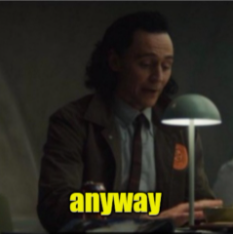

There could be baseline we can define too where logistic regression will be used. We need to scale the data. This will be done only to a dataset used for determining the baseline. The original values will be "untouched" and later a pipeline will be constructed where different preprocessing techniques could be applied for every classifer used.

In [13]:
# Copy the original data to a base dataset
X_base = X.copy()
y_base = y.copy()

# StandardScaler() - attack/defence attributes
col_to_ss = ["home_team_att", "away_team_att", "home_team_def", "away_team_def"]
col_ss = pd.DataFrame(StandardScaler().fit_transform(X_base[col_to_ss]),
                      index = X_base[col_to_ss].index,
                      columns = X_base[col_to_ss].columns)

X_base = pd.concat([col_ss, X_base.drop(col_to_ss, axis = 1)], axis = 1)

# MinMaxScaler() - year, week
col_to_mm = ["year", "home_team_week", "away_team_week"]
col_mm = pd.DataFrame(MinMaxScaler().fit_transform(X_base[col_to_mm]),
                      index = X_base[col_to_mm].index,
                      columns = X_base[col_to_mm].columns)

X_base = pd.concat([col_mm, X_base.drop(col_to_mm, axis = 1)], axis = 1)
X_base.describe()

,year,home_team_week,away_team_week,home_team_att,away_team_att,home_team_def,away_team_def,home_team_Arsenal,home_team_Aston Villa,home_team_Birmingham,...,away_team_Southampton,away_team_Stoke,away_team_Sunderland,away_team_Swansea,away_team_Tottenham,away_team_Watford,away_team_West Brom,away_team_West Ham,away_team_Wigan,away_team_Wolves
count,8090.000000,8090.000000,8090.000000,8.090000e+03,8.090000e+03,8.090000e+03,8.090000e+03,8090.000000,8090.000000,8090.000000,...,8090.000000,8090.000000,8090.000000,8090.000000,8090.000000,8090.000000,8090.000000,8090.000000,8090.000000,8090.000000
mean,0.483313,0.495106,0.494972,-4.100552e-17,-2.246246e-15,-6.756030e-16,-7.045593e-17,0.050062,0.042892,0.016440,...,0.033498,0.023486,0.032880,0.016440,0.050062,0.014833,0.030532,0.042892,0.018789,0.017182
std,0.292753,0.297593,0.297518,1.000062e+00,1.000062e+00,1.000062e+00,1.000062e+00,0.218086,0.202627,0.127168,...,0.179944,0.151450,0.178334,0.127168,0.218086,0.120892,0.172055,0.202627,0.135786,0.129956
min,0.000000,0.000000,0.000000,-2.094065e+00,-1.953337e+00,-2.308336e+00,-3.184710e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.238095,0.243243,0.243243,-7.237676e-01,-7.394668e-01,-7.102435e-01,-6.182786e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.476190,0.486486,0.486486,-1.967302e-01,-2.371758e-01,-1.291189e-01,1.697679e-02,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.756757,0.756757,5.411221e-01,5.162608e-01,5.972870e-01,6.522322e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,4.124976e+00,5.601958e+00,3.996866e+00,3.320305e+00,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Split

For baseline estimation 20% of the data will be our test set. Further different splits could be applied to determine what is the best way we could pipe the data to the model.*

** Teams are changing through the years. Only six teams(cell 3 for more info) are consistanly contained in all seasons, so maybe good idea is to select 4-5 consecutive seasons to train and predict the next one, but that will be checked furter*

In [14]:
# train, test separation, test = 20 %
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base, y_base, 
                                                    test_size = 0.2,
                                                    stratify = y_base,
                                                    random_state = rnd)

In [15]:
X_train_base.shape, X_test_base.shape

((6472, 95), (1618, 95))

### Base LR

              precision    recall  f1-score   support

           0       0.59      0.79      0.68       743
           1       0.29      0.09      0.14       405
           2       0.55      0.58      0.56       470

    accuracy                           0.56      1618
   macro avg       0.48      0.49      0.46      1618
weighted avg       0.50      0.56      0.51      1618

Counts of real classes:      {0: 743, 1: 405, 2: 470}
Counts of predicted classes: {0: 994, 1: 123, 2: 501}


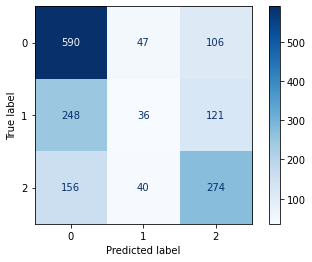

In [16]:
LR_base = LogisticRegression(random_state = rnd, max_iter = 200)
fit_predict_report(LR_base, X_train_base, y_train_base, X_test_base, y_test_base)

That's a good start. We already beat the bad guys with 3% :)  

The accuracy could be used as a main metric. However f1 score is pretty low for drawn matches. Lets see if there will be improvement if we tune the class weights.

              precision    recall  f1-score   support

           0       0.65      0.58      0.61       743
           1       0.27      0.29      0.28       405
           2       0.52      0.58      0.55       470

    accuracy                           0.51      1618
   macro avg       0.48      0.48      0.48      1618
weighted avg       0.52      0.51      0.51      1618

Counts of real classes:      {0: 743, 1: 405, 2: 470}
Counts of predicted classes: {0: 665, 1: 429, 2: 524}


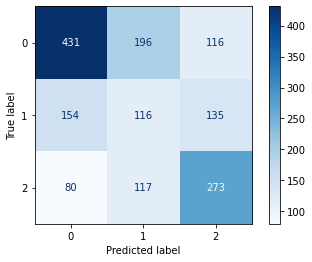

In [17]:
LR_base_weights = LogisticRegression(random_state = rnd, max_iter = 200 , class_weight = "balanced")
fit_predict_report(LR_base_weights, X_train_base, y_train_base, X_test_base, y_test_base)

Some class 0 predictions moved to class 1 and class 2 is almost not affected, but the overall accuracy has dropped.
  
We have our baseline and we have idea where we need to improve our forecasts so lets try to work on this one and few other models. For that we will use gridsearch with incorporated pipeline where different transformers of the data can be passed like scalers and feature transforms.  

### Transformers

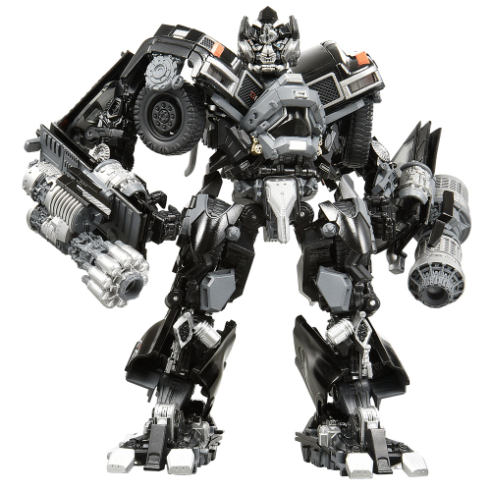

Here we take the un-preprocessed data to which we'll apply the same preprocessing as before and will try few other transformation types. For that we'll make one main transformer that unify all steps in one which also will support the transform method. That alows the usage in a pipeline.
  
Addition two transformers will be added where instead of Standard scaler the RobustScaler/Quantile transformer will be used.

In [18]:
# minmax/standard scalers transformer
mm_ss_transformer = make_column_transformer(
    (MinMaxScaler(), ["year", "home_team_week", "away_team_week"]),
    (StandardScaler(), ["home_team_att", "away_team_att", "home_team_def", "away_team_def"]),
    remainder = "passthrough")

# minmax/robust scalers
mm_rt_transformer = make_column_transformer(
    (MinMaxScaler(), ["year", "home_team_week", "away_team_week"]),
    (RobustScaler(), ["home_team_att", "away_team_att", "home_team_def", "away_team_def"]),
    remainder = "passthrough")

# minmax scaler/quantile transformer
mm_qt_transformer = make_column_transformer(
    (MinMaxScaler(), ["year", "home_team_week", "away_team_week"]),
    (QuantileTransformer(), ["home_team_att", "away_team_att", "home_team_def", "away_team_def"]),
    remainder = "passthrough")


Before we start hyperparameter tunning lets see if the different scalers have significant impact on the model performance in order to limit further steps. 

In [19]:
# _tr stands for transformer
X_tr_train, X_tr_test, y_tr_train, y_tr_test = train_test_split(X, y, 
                                                                test_size = 0.2,
                                                                stratify = y,
                                                                random_state = rnd)

In [20]:
# dummy pipeline - arbitrary "tf" steps could beadded
pipe_tr = Pipeline([("tf_1", "passthrough"),
                    ("tf_2", "passthrough"),
                    ("tf_3", "passthrough"),
                    ("clf", "passthrough"),
                   ])

# Define transformers and classifiers with their hyperparameters.
# To each hyperparamter should be added "clf__" in the beginning.
# If no transformers the step could be skipped or set as "passthrough". "passthrough" and transformer could be combined.
# "tf_2/3/4..." could be added as options for more transformers to be applied to the data.
# If more then one transformer in "tf_1/2/3/4" model will be evaluated with every single transformer.
# if some hyperparameter is incompetible with other the step will throw non-interuptive exception and basically will be skipped.
# the result will be saved as "NaN" in cv_results_
params_grid_tr = [
                    {
                    "tf_1": ["passthrough", PolynomialFeatures(degree = 2)],
                    "tf_2": [MinMaxScaler(), StandardScaler(), RobustScaler(), QuantileTransformer()],
                    "tf_3": ["passthrough", PCA(2), PCA(3), PCA(5), PCA(8)],
                    "clf": [LogisticRegression(random_state = rnd, max_iter = 200)],                
                    }, 
                  ]

grid_lr_tr = GridSearchCV(pipe_tr, params_grid_tr, scoring = "accuracy", n_jobs = -1, cv = 5)
grid_lr_tr.fit(X_tr_train, y_tr_train)

res_lr_tr = pd.DataFrame(grid_lr_tr.cv_results_)

In [21]:
pd.set_option("display.max_colwidth", None)
print(grid_lr_tr.best_params_)
res_lr_tr.sort_values(by = ["rank_test_score"], axis = 0)

{'clf': LogisticRegression(max_iter=200), 'tf_1': 'passthrough', 'tf_2': RobustScaler(), 'tf_3': PCA(n_components=8)}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_tf_1,param_tf_2,param_tf_3,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,0.370361,0.029169,0.014665,0.000882,LogisticRegression(max_iter=200),passthrough,RobustScaler(),PCA(n_components=8),"{'clf': LogisticRegression(max_iter=200), 'tf_1': 'passthrough', 'tf_2': RobustScaler(), 'tf_3': PCA(n_components=8)}",0.580695,0.575290,0.560278,0.552550,0.564915,0.566746,0.010142,1
13,0.306820,0.021500,0.019354,0.004107,LogisticRegression(max_iter=200),passthrough,RobustScaler(),PCA(n_components=5),"{'clf': LogisticRegression(max_iter=200), 'tf_1': 'passthrough', 'tf_2': RobustScaler(), 'tf_3': PCA(n_components=5)}",0.579151,0.576834,0.561824,0.553323,0.561051,0.566436,0.009920,2
12,0.277109,0.011726,0.016036,0.000662,LogisticRegression(max_iter=200),passthrough,RobustScaler(),PCA(n_components=3),"{'clf': LogisticRegression(max_iter=200), 'tf_1': 'passthrough', 'tf_2': RobustScaler(), 'tf_3': PCA(n_components=3)}",0.574517,0.578378,0.555641,0.556414,0.566461,0.566282,0.009217,3
11,0.291087,0.015656,0.021404,0.007388,LogisticRegression(max_iter=200),passthrough,RobustScaler(),PCA(n_components=2),"{'clf': LogisticRegression(max_iter=200), 'tf_1': 'passthrough', 'tf_2': RobustScaler(), 'tf_3': PCA(n_components=2)}",0.575290,0.576834,0.554869,0.554096,0.564915,0.565201,0.009667,4
19,0.517131,0.019795,0.055027,0.005933,LogisticRegression(max_iter=200),passthrough,QuantileTransformer(),PCA(n_components=8),"{'clf': LogisticRegression(max_iter=200), 'tf_1': 'passthrough', 'tf_2': QuantileTransformer(), 'tf_3': PCA(n_components=8)}",0.576834,0.570656,0.554869,0.564142,0.558733,0.565047,0.007933,5
17,0.446867,0.012542,0.054377,0.007061,LogisticRegression(max_iter=200),passthrough,QuantileTransformer(),PCA(n_components=3),"{'clf': LogisticRegression(max_iter=200), 'tf_1': 'passthrough', 'tf_2': QuantileTransformer(), 'tf_3': PCA(n_components=3)}",0.571429,0.576062,0.557960,0.550232,0.566461,0.564429,0.009294,6
18,0.469140,0.016984,0.047867,0.002074,LogisticRegression(max_iter=200),passthrough,QuantileTransformer(),PCA(n_components=5),"{'clf': LogisticRegression(max_iter=200), 'tf_1': 'passthrough', 'tf_2': QuantileTransformer(), 'tf_3': PCA(n_components=5)}",0.573745,0.572973,0.554869,0.557960,0.561824,0.564274,0.007742,7
16,0.438422,0.009388,0.049376,0.001223,LogisticRegression(max_iter=200),passthrough,QuantileTransformer(),PCA(n_components=2),"{'clf': LogisticRegression(max_iter=200), 'tf_1': 'passthrough', 'tf_2': QuantileTransformer(), 'tf_3': PCA(n_components=2)}",0.566795,0.577606,0.557187,0.551005,0.559505,0.562420,0.009121,8
36,28.918710,1.130738,3.180216,0.301861,LogisticRegression(max_iter=200),PolynomialFeatures(),QuantileTransformer(),PCA(n_components=2),"{'clf': LogisticRegression(max_iter=200), 'tf_1': PolynomialFeatures(), 'tf_2': QuantileTransformer(), 'tf_3': PCA(n_components=2)}",0.561390,0.572973,0.548686,0.553323,0.561824,0.559639,0.008313,9
9,0.302027,0.018358,0.016135,0.002967,LogisticRegression(max_iter=200),passthrough,StandardScaler(),PCA(n_components=8),"{'clf': LogisticRegression(max_iter=200), 'tf_1': 'passthrough', 'tf_2': StandardScaler(), 'tf_3': PCA(n_components=8)}",0.561390,0.566023,0.554096,0.555641,0.560278,0.559486,0.004262,10


Using different transformers doesn't have big impact on the results of a logistic regression with same parameters. Here we have various combinations with/without polynomial features and with/without dimensionality reduction (PCA) and these combined with four different scalers. Notice that the scalers are applied to the whole dataset - not the way they were applied previously(minmax for some columns and standard for other).  

The conclusion we could make is that we can use whatever transformer we need for the specific model as every model have its "requirements" to the data or we could try several to a model - we have a pipline for convenience. Nevertheless we have a transformer that stands out a little bit and that is the robust scaler combined with PCA so we could use this combinationand lets see how the model performs on the test data.

In [22]:
pipe_best_tr_lr = Pipeline([("mm_rt", mm_rt_transformer),
                            ("PCA", PCA(5)),
                            ("clf", LogisticRegression(random_state = rnd, max_iter = 200)),
                           ])

              precision    recall  f1-score   support

           0       0.59      0.83      0.69       743
           1       0.45      0.02      0.05       405
           2       0.50      0.59      0.54       470

    accuracy                           0.56      1618
   macro avg       0.52      0.48      0.43      1618
weighted avg       0.53      0.56      0.49      1618

Counts of real classes:      {0: 743, 1: 405, 2: 470}
Counts of predicted classes: {0: 1042, 1: 22, 2: 554}


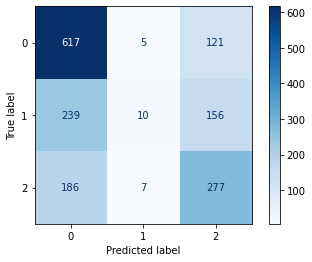

In [23]:
fit_predict_report(pipe_best_tr_lr, X_tr_train, y_tr_train, X_tr_test, y_tr_test)

The accuracy remains the same as in our baseline model, but the f1 score dropped so probbaly we could use f1 as metric too.

### Models

Used data will be limited to 4 seasons in order to make faster gridsearch.

In [24]:
# take just ~20 % of the data. seasons 2015-2018. _hp stands for hyperparameter
X_hp = X[(X.year >=2015) & (X.year <=2018)].copy()
y_hp = y.take(X_hp.index, axis = 0)
X_hp.shape, y_hp.shape

((1520, 95), (1520,))

In [25]:
# train, test separation, test = 20 %
X_hp_train, X_hp_test, y_hp_train, y_hp_test = train_test_split(X_hp, y_hp, 
                                                                test_size = 0.2,
                                                                stratify = y_hp,
                                                                random_state = rnd)

In [26]:
X_hp_train.shape, X_hp_test.shape, y_hp_train.shape, y_hp_test.shape

((1216, 95), (304, 95), (1216,), (304,))

We will test a bunch of classifiers where hyperparameters will be left as they are by default or few of them will be alternated.  

The gridsearch gives the opportunity to use custom scorer or several custom scorers at once, i.e we could rank every model by different metrics. As we saw from the base logistic regression, the model is biased towards predicting home/away wins and almost never draws. We could evaluate how every model predicts each class and if suitable combine results from several models - i.e. use one model to predict draws and other/s for the other outcomes.  

Our custom scorers will be F1 for each class and as an addition the accuracy and F1(averaged between classes).

In [27]:
scorer_class_0 = make_scorer(f1_score, average = "macro", labels = [0])
scorer_class_1 = make_scorer(f1_score, average = "macro", labels = [1])
scorer_class_2 = make_scorer(f1_score, average = "macro", labels = [2])
accuracy_all = make_scorer(accuracy_score)
f1_all = make_scorer(f1_score, average = "macro")

In [28]:
# ========== Models
LR = LogisticRegression(random_state = rnd)
KN = KNeighborsClassifier()
RN = RadiusNeighborsClassifier()
RF = RandomForestClassifier(random_state = rnd)
ET = ExtraTreesClassifier(random_state = rnd)
GNB = GaussianNB()
SV = SVC(random_state = rnd, cache_size = 2000)

In [29]:
pipe_hp = Pipeline([("tf_1", "passthrough"),
                    ("tf_2", "passthrough"),
                    ("tf_3", "passthrough"),
                    ("clf", "passthrough"),
                   ])

params_grid_hp = [
                   # LogisticRegression - l2 penalty
                   {
                    "tf_1": [mm_ss_transformer],
                    "tf_2": [PCA(9)],
                    "clf": [LR],
                    "clf__multi_class": ["multinomial"],
                    "clf__solver": ["lbfgs"],
                    "clf__C": [50],
                    "clf__penalty": ["l2"],
                    "clf__max_iter": [500],
                    "clf__class_weight": ["balanced"],
                    }, 
                   
    
                   # LogisticRegression - l1/elasticnet penalty 
                   {
                    "tf_1": [mm_ss_transformer],
                    "tf_2": [PCA(9)],
                    "clf": [LR],
                    "clf__multi_class": ["multinomial"],
                    "clf__solver": ["saga"],
                    "clf__C": [1e3],
                    "clf__fit_intercept": [True],
                    "clf__penalty": ["l1"],
                    "clf__max_iter": [500],
                    "clf__class_weight": ["balanced"],
                    },
                   
                   # KNeighborsClassifier
                   {
                    "tf_1": [mm_rt_transformer],
                    "tf_2": [PolynomialFeatures(2)],
                    "tf_3": [PCA(15)],
                    "clf": [KN],
                    "clf__n_neighbors": [11],
                    "clf__weights": ["uniform"],
                    },

                   # RadiusNeighborsClassifier
                   {
                    "tf_1": [mm_ss_transformer],
                    "tf_2": [PCA(1)],
                    "clf": [RN],
                    "clf__radius": [2.5],
                    "clf__weights": ["distance"],
                    "clf__outlier_label": ["most_frequent"],
                    },

                   # RandomForestClassifier
                   {
                    "tf_1": [PCA(5)],
                    "clf": [RF],
                    "clf__n_estimators": [100],
                    "clf__criterion": ["gini"],
                    "clf__bootstrap": [True],
                    "clf__class_weight": ["balanced"]
                    },

                   # ExtraTreesClassifier
                   {
                    "tf_1": [PolynomialFeatures(2)],
                    "clf": [ET],
                    "clf__n_estimators": [100],
                    "clf__criterion": ["entropy"],
                    "clf__bootstrap": [False],
                    "clf__class_weight": ["balanced"]
                    },

                   # GaussianNB
                   {
                    "tf_1": [mm_rt_transformer],
                    "tf_2": [PolynomialFeatures(2)],
                    "tf_3": [PCA(9)],
                    "clf": [GNB],
                    "clf__var_smoothing":[0.1]
                    },

    
                   # SV - kernel = rbf
                   {
                    "tf_1": [mm_rt_transformer],
                    "clf": [SV],
                    "clf__kernel": ["rbf"],
                    "clf__decision_function_shape": ["ovo"],
                    "clf__C": [1e3],
                    "clf__gamma": [1],
                    },
                ]


# -------- gridsearch
grid_hp = GridSearchCV(pipe_hp,
                       params_grid_hp,
                       scoring = {"accuracy": accuracy_all,
                                  "f1_all": f1_all,
                                  "scorer_class_0": scorer_class_0,
                                  "scorer_class_1": scorer_class_1,
                                  "scorer_class_2": scorer_class_2},
                       n_jobs = -1,
                       cv = 5,
                       refit = "f1_all",
                       verbose = True)

grid_hp.fit(X_hp_train, y_hp_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf_1', 'passthrough'),
                                       ('tf_2', 'passthrough'),
                                       ('tf_3', 'passthrough'),
                                       ('clf', 'passthrough')]),
             n_jobs=-1,
             param_grid=[{'clf': [LogisticRegression(C=50,
                                                     class_weight='balanced',
                                                     max_iter=500,
                                                     multi_class='multinomial')],
                          'clf__C': [50], 'clf__class_weight': ['balanced'],
                          'clf__max_iter': [500],
                          'clf__multi_class': ['mult...
                                                                     'home_team_def',
                                                                     'away_team_def'])])]}],
             refit='f1_all',
             scoring={'

### The author is an ...  $_{idiot}$

All models above have been evaluated with a broad variety of hyperparameter settings. At first all models were fitted with almost no hyperparameter changes from the default settings with the idea some of them(models) to be eliminated. Unfortunately(or not) every model has its strengths. Some models predict better draws, other have better accuracy, etc.  

After that intervention all models were evaluated one by one with extensive hyperparameter tunning where even the initial transformers(and different combinations between them) were included for some models. After a gridsearch all results are sorted from best to worst for particular the model. Best 8-10 combinations of hyperparameters are compared to the worst 8-10. This way some hyperparameter stands out and could be eliminated. Оthers show in what range is their best value.

Example(the number in front is the index of the gridsearch iteration):  
  
22 {'clf__var_smoothing': 0.1, 'tf_3': PCA(n_components=8)}  
23 {'clf__var_smoothing': 0.1, 'tf_3': PCA(n_components=11)}  
24 {'clf__var_smoothing': 0.1, 'tf_3': PCA(n_components=14)}  
17 {'clf__var_smoothing': 0.001, 'tf_3': PCA(n_components=8)}  
12 {'clf__var_smoothing': 1e-05, 'tf_3': PCA(n_components=8)}  
2 {'clf__var_smoothing': 1e-09, 'tf_3': PCA(n_components=8)}  
7 {'clf__var_smoothing': 1e-07, 'tf_3': PCA(n_components=8)}  
14 {'clf__var_smoothing': 1e-05, 'tf_3': PCA(n_components=14)}  
19 {'clf__var_smoothing': 0.001, 'tf_3': PCA(n_components=14)}  
4 {'clf__var_smoothing': 1e-09, 'tf_3': PCA(n_components=14)}  
9 {'clf__var_smoothing': 1e-07, 'tf_3': PCA(n_components=14)}  
8 {'clf__var_smoothing': 1e-07, 'tf_3': PCA(n_components=11)}  
18 {'clf__var_smoothing': 0.001, 'tf_3': PCA(n_components=11)}  
13 {'clf__var_smoothing': 1e-05, 'tf_3': PCA(n_components=11)}  
3 {'clf__var_smoothing': 1e-09, 'tf_3': PCA(n_components=11)}  
21 {'clf__var_smoothing': 0.1, 'tf_3': PCA(n_components=5)}  
6 {'clf__var_smoothing': 1e-07, 'tf_3': PCA(n_components=5)}  
16 {'clf__var_smoothing': 0.001, 'tf_3': PCA(n_components=5)}  
1 {'clf__var_smoothing': 1e-09, 'tf_3': PCA(n_components=5)}  
11 {'clf__var_smoothing': 1e-05, 'tf_3': PCA(n_components=5)}  
20 {'clf__var_smoothing': 0.1, 'tf_3': 'passthrough'}  
15 {'clf__var_smoothing': 0.001, 'tf_3': 'passthrough'}  
10 {'clf__var_smoothing': 1e-05, 'tf_3': 'passthrough'}  
0 {'clf__var_smoothing': 1e-09, 'tf_3': 'passthrough'}  
5 {'clf__var_smoothing': 1e-07, 'tf_3': 'passthrough'}  

In the above example easily can be seen that lack of PCA leads to worse results and the exact value of n_components in the PCA should be searched in the ~8-14 range. 

So why this title and this extensive explanation? Well because all the steps above as a temporary state of the models were not saved and only the final settings are present.

#### Average performance of each model

In [30]:
grid_model_results = convert_cv_results(grid_hp.cv_results_)
grid_model_results.sort_values("mean_f1", ascending = False)

,mean_accuracy,mean_f1,mean_f1_class_0,mean_f1_class_1,mean_f1_class_2,mean_fit_time
classifier,,,,,,
LogisticRegression,0.546860,0.521401,0.662589,0.337229,0.564386,0.143619
GaussianNB,0.541108,0.518736,0.638052,0.345430,0.572726,0.863909
KNeighborsClassifier,0.533735,0.460142,0.670103,0.203144,0.507178,1.179272
RandomForestClassifier,0.539472,0.458392,0.674053,0.171112,0.530011,0.959775
RadiusNeighborsClassifier,0.527150,0.454186,0.649278,0.192769,0.520510,0.079039
ExtraTreesClassifier,0.509064,0.435799,0.635039,0.170665,0.501694,7.332109
SVC,0.526327,0.430532,0.658006,0.142957,0.490632,0.490341


#### Best models for each metric

In [31]:
# best f1_macro
best_metric(grid_hp.cv_results_, metric = "mean_test_f1_all", rows_to_show = 100 ,show_other_metrics = True)

,classifier,mean_test_accuracy,mean_test_f1_all,mean_test_scorer_class_0,mean_test_scorer_class_1,mean_test_scorer_class_2,mean_fit_time,mean_score_time
0,LogisticRegression,0.547686,0.522333,0.664237,0.340498,0.562263,0.155552,0.044132
1,LogisticRegression,0.546033,0.520470,0.660941,0.333959,0.566509,0.131685,0.036593
6,GaussianNB,0.541108,0.518736,0.638052,0.345430,0.572726,0.863909,0.081784
2,KNeighborsClassifier,0.533735,0.460142,0.670103,0.203144,0.507178,1.179272,0.124919
4,RandomForestClassifier,0.539472,0.458392,0.674053,0.171112,0.530011,0.959775,0.068485
3,RadiusNeighborsClassifier,0.527150,0.454186,0.649278,0.192769,0.520510,0.079039,0.091307
5,ExtraTreesClassifier,0.509064,0.435799,0.635039,0.170665,0.501694,7.332109,0.102873
7,SVC,0.526327,0.430532,0.658006,0.142957,0.490632,0.490341,0.197450


In [32]:
# best accuracy
best_metric(grid_hp.cv_results_, metric = "mean_test_accuracy", rows_to_show = 10)

,classifier,mean_test_accuracy,mean_fit_time,mean_score_time
0,LogisticRegression,0.547686,0.155552,0.044132
1,LogisticRegression,0.546033,0.131685,0.036593
6,GaussianNB,0.541108,0.863909,0.081784
4,RandomForestClassifier,0.539472,0.959775,0.068485
2,KNeighborsClassifier,0.533735,1.179272,0.124919
3,RadiusNeighborsClassifier,0.527150,0.079039,0.091307
7,SVC,0.526327,0.490341,0.197450
5,ExtraTreesClassifier,0.509064,7.332109,0.102873


In [33]:
# best F1 for Class 0
best_metric(grid_hp.cv_results_, metric = "mean_test_scorer_class_0", rows_to_show = 10)

,classifier,mean_test_scorer_class_0,mean_fit_time,mean_score_time
4,RandomForestClassifier,0.674053,0.959775,0.068485
2,KNeighborsClassifier,0.670103,1.179272,0.124919
0,LogisticRegression,0.664237,0.155552,0.044132
1,LogisticRegression,0.660941,0.131685,0.036593
7,SVC,0.658006,0.490341,0.197450
3,RadiusNeighborsClassifier,0.649278,0.079039,0.091307
6,GaussianNB,0.638052,0.863909,0.081784
5,ExtraTreesClassifier,0.635039,7.332109,0.102873


In [34]:
# best F1 for Class 1
best_metric(grid_hp.cv_results_, metric = "mean_test_scorer_class_1", rows_to_show = 10)

,classifier,mean_test_scorer_class_1,mean_fit_time,mean_score_time
6,GaussianNB,0.345430,0.863909,0.081784
0,LogisticRegression,0.340498,0.155552,0.044132
1,LogisticRegression,0.333959,0.131685,0.036593
2,KNeighborsClassifier,0.203144,1.179272,0.124919
3,RadiusNeighborsClassifier,0.192769,0.079039,0.091307
4,RandomForestClassifier,0.171112,0.959775,0.068485
5,ExtraTreesClassifier,0.170665,7.332109,0.102873
7,SVC,0.142957,0.490341,0.197450


In [35]:
# best F1 for Class 2
best_metric(grid_hp.cv_results_, metric = "mean_test_scorer_class_2", rows_to_show = 10)

,classifier,mean_test_scorer_class_2,mean_fit_time,mean_score_time
6,GaussianNB,0.572726,0.863909,0.081784
1,LogisticRegression,0.566509,0.131685,0.036593
0,LogisticRegression,0.562263,0.155552,0.044132
4,RandomForestClassifier,0.530011,0.959775,0.068485
3,RadiusNeighborsClassifier,0.520510,0.079039,0.091307
2,KNeighborsClassifier,0.507178,1.179272,0.124919
5,ExtraTreesClassifier,0.501694,7.332109,0.102873
7,SVC,0.490632,0.490341,0.197450


After the hyperparameters tuning the logistic regression improved its result on drawn matches, but they are still difficult to predict. Even with f1 score of 0.34 for class 1 it's the best model forecasting draws. Actually it turns out the LR is the best overall model. Time for the test data.

### Test data


# ================= LogisticRegression
              precision    recall  f1-score   support

           0       0.70      0.58      0.63       140
           1       0.33      0.35      0.34        72
           2       0.59      0.72      0.65        92

    accuracy                           0.57       304
   macro avg       0.54      0.55      0.54       304
weighted avg       0.58      0.57      0.57       304

Counts of real classes:      {0: 140, 1: 72, 2: 92}
Counts of predicted classes: {0: 116, 1: 76, 2: 112}


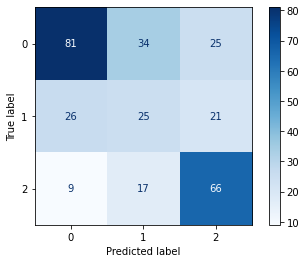


# ================= LogisticRegression
              precision    recall  f1-score   support

           0       0.72      0.61      0.66       140
           1       0.36      0.35      0.35        72
           2       0.58      0.73      0.65        92

    accuracy                           0.59       304
   macro avg       0.55      0.56      0.55       304
weighted avg       0.59      0.59      0.58       304

Counts of real classes:      {0: 140, 1: 72, 2: 92}
Counts of predicted classes: {0: 120, 1: 69, 2: 115}


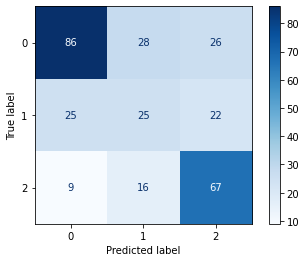


# ================= KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.61      0.80      0.69       140
           1       0.31      0.15      0.20        72
           2       0.62      0.57      0.59        92

    accuracy                           0.58       304
   macro avg       0.51      0.51      0.50       304
weighted avg       0.54      0.58      0.55       304

Counts of real classes:      {0: 140, 1: 72, 2: 92}
Counts of predicted classes: {0: 184, 1: 36, 2: 84}


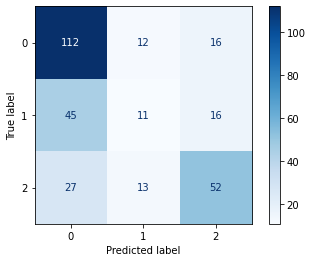


# ================= RadiusNeighborsClassifier
              precision    recall  f1-score   support

           0       0.56      0.62      0.59       140
           1       0.27      0.21      0.24        72
           2       0.57      0.59      0.58        92

    accuracy                           0.51       304
   macro avg       0.47      0.47      0.47       304
weighted avg       0.50      0.51      0.50       304

Counts of real classes:      {0: 140, 1: 72, 2: 92}
Counts of predicted classes: {0: 155, 1: 55, 2: 94}


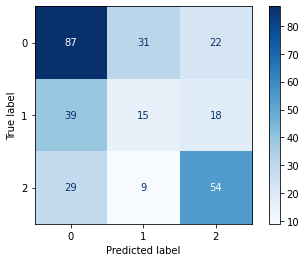


# ================= RandomForestClassifier
              precision    recall  f1-score   support

           0       0.62      0.75      0.68       140
           1       0.33      0.17      0.22        72
           2       0.58      0.62      0.60        92

    accuracy                           0.57       304
   macro avg       0.51      0.51      0.50       304
weighted avg       0.54      0.57      0.55       304

Counts of real classes:      {0: 140, 1: 72, 2: 92}
Counts of predicted classes: {0: 169, 1: 36, 2: 99}


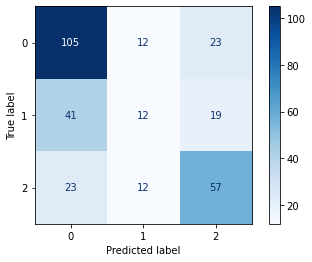


# ================= ExtraTreesClassifier
              precision    recall  f1-score   support

           0       0.62      0.71      0.66       140
           1       0.36      0.22      0.27        72
           2       0.59      0.63      0.61        92

    accuracy                           0.57       304
   macro avg       0.52      0.52      0.51       304
weighted avg       0.55      0.57      0.55       304

Counts of real classes:      {0: 140, 1: 72, 2: 92}
Counts of predicted classes: {0: 160, 1: 45, 2: 99}


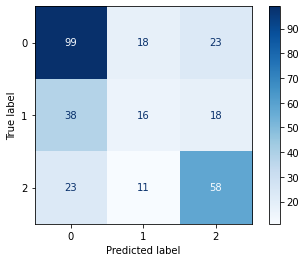


# ================= GaussianNB
              precision    recall  f1-score   support

           0       0.70      0.54      0.61       140
           1       0.33      0.39      0.36        72
           2       0.60      0.73      0.66        92

    accuracy                           0.56       304
   macro avg       0.54      0.55      0.54       304
weighted avg       0.58      0.56      0.57       304

Counts of real classes:      {0: 140, 1: 72, 2: 92}
Counts of predicted classes: {0: 109, 1: 84, 2: 111}


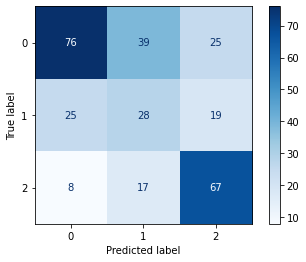


# ================= SVC
              precision    recall  f1-score   support

           0       0.59      0.73      0.65       140
           1       0.27      0.17      0.21        72
           2       0.64      0.59      0.61        92

    accuracy                           0.55       304
   macro avg       0.50      0.49      0.49       304
weighted avg       0.53      0.55      0.53       304

Counts of real classes:      {0: 140, 1: 72, 2: 92}
Counts of predicted classes: {0: 174, 1: 45, 2: 85}


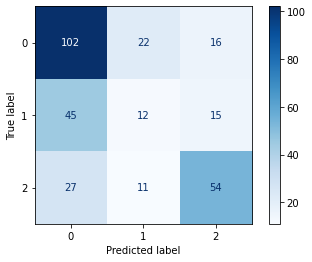

In [36]:
# ---------- setup of all models
# random_state removed from the models to test with other seeds

# LR l2
LR_l2_tuned = LogisticRegression(penalty = "l2", C = 50, solver = "lbfgs", max_iter = 500,
                                 multi_class = "multinomial",fit_intercept = True,
                                 class_weight = "balanced")
LR_l2_pipe = [('scaler1', mm_ss_transformer), ('PCA', PCA(9)), ('lr', LR_l2_tuned)]



# LR l1
LR_l1_tuned = LogisticRegression(penalty = "l1", C = 1e3, solver = "saga", max_iter = 500,
                                 multi_class = "multinomial", fit_intercept = True,
                                 class_weight = "balanced")
LR_l1_pipe = [('scaler1', mm_ss_transformer), ('PCA', PCA(9)), ('lr', LR_l1_tuned)]


# KN
KN_tuned = KNeighborsClassifier(n_neighbors = 11, weights = "uniform")
KN_pipe = [('scaler1', mm_rt_transformer), ("poly", PolynomialFeatures(2)), ('PCA', PCA(15)), ('rn', KN_tuned)]


# RN
RN_tuned = RadiusNeighborsClassifier(radius = 2.5, weights = "distance", outlier_label = "most_frequent")
RN_pipe = [('scaler1', mm_ss_transformer),
           ('PCA', PCA(1)), ('rn', RN_tuned)]


# RF
RF_tuned = RandomForestClassifier(n_estimators = 100, criterion = "gini", bootstrap = True)
RF_pipe = [('PCA', PCA(5)), ('rn', RF_tuned)]

# ET
ET_tuned = ExtraTreesClassifier(n_estimators = 100, criterion = "entropy", class_weight = "balanced", bootstrap = False)
ET_pipe = [("poly", PolynomialFeatures(2)), ('rn', ET_tuned)]

# GNB
GNB_tuned = GaussianNB(var_smoothing = 0.1)
GNB_pipe = [('scaler1', mm_rt_transformer), ("poly", PolynomialFeatures(2)), ('PCA', PCA(9)), ('rn', GNB_tuned)]


# SVC
SV_tuned = SVC(kernel = "rbf", decision_function_shape = "ovo", C = 1e3, gamma = 1, probability = True)
SV_pipe = [('scaler1', mm_rt_transformer), ('rn', SV_tuned)]

# all collected in lists
tuned_models = [LR_l2_tuned, LR_l1_tuned, KN_tuned, RN_tuned, RF_tuned, ET_tuned, GNB_tuned, SV_tuned]
pipes_tst = [LR_l2_pipe, LR_l1_pipe, KN_pipe, RN_pipe, RF_pipe, ET_pipe, GNB_pipe, SV_pipe]

# ---------- pipeline
for pipe in pipes_tst:
    pipe_tst = Pipeline(pipe)
    print(f"\n# ================= {pipe[-1][1].__class__.__name__}")
    fit_predict_report(pipe_tst, X_hp_train, y_hp_train, X_hp_test, y_hp_test)

The logistic regression is stable with "unseen" data. What we can do now is to try boost these algorithms.

### Boost

#### GradientBoostingClassifier

In [37]:
GB = GradientBoostingClassifier(random_state = rnd)

# Create pipeline
pipe_boost = Pipeline([("tf_1", "passthrough"),
                       ("tf_2", "passthrough"),
                       ("tf_3", "passthrough"),
                       ("boost", "passthrough"),
                   ])

params_grid_boost = [
                       # LogisticRegression - l2 penalty
                       {
                        "tf_1": [mm_ss_transformer],
                        "tf_2": [PCA(9)],
                        "boost": [GB],
                        "boost__init": [LR_l2_tuned],
                        "boost__loss": ["deviance"],
                        }, 
                   
    
                   # LogisticRegression - l1/elasticnet penalty 
                   {
                    "tf_1": [mm_ss_transformer],
                    "tf_2": [PCA(9)],
                    "boost": [GB],
                    "boost__init": [LR_l1_tuned],
                    "boost__loss": ["deviance"],
                    },
                   
                   # KNeighborsClassifier
                   {
                    "tf_1": [mm_rt_transformer],
                    "tf_2": [PolynomialFeatures(2)],
                    "tf_3": [PCA(15)],
                    "boost": [GB],
                    "boost__init": [KN_tuned],
                    "boost__loss": ["deviance"],
                    },

                   # RadiusNeighborsClassifier
                   {
                    "tf_1": [mm_ss_transformer],
                    "tf_2": [PCA(1)],
                    "boost": [GB],
                    "boost__init": [RN_tuned],
                    "boost__loss": ["deviance"],
                    },

                   # RandomForestClassifier
                   {
                    "tf_1": [PCA(5)],
                    "boost": [GB],
                    "boost__init": [RF_tuned],
                    "boost__loss": ["deviance"],
                    },

                   # ExtraTreesClassifier
                   {
                    "tf_1": [PolynomialFeatures(2)],
                    "boost": [GB],
                    "boost__init": [ET_tuned],
                    "boost__loss": ["deviance"],
                    },

                   # GaussianNB
                   {
                    "tf_1": [mm_rt_transformer],
                    "tf_2": [PolynomialFeatures(2)],
                    "tf_3": [PCA(9)],
                    "boost": [GB],
                    "boost__init": [GNB_tuned],
                    "boost__loss": ["deviance"],
                    },

    
                   # SV - kernel = rbf
                   {
                    "tf_1": [mm_rt_transformer],
                    "boost": [GB],
                    "boost__init": [SV_tuned],
                    "boost__loss": ["deviance"],
                    },
                ]


# -------- gridsearch
grid_boost = GridSearchCV(pipe_boost,
                          params_grid_boost,
                          scoring = {"accuracy": accuracy_all,
                                     "f1_all": f1_all,
                                     "scorer_class_0": scorer_class_0,
                                     "scorer_class_1": scorer_class_1,
                                     "scorer_class_2": scorer_class_2},
                          n_jobs = -1,
                          cv = 2,
                          refit = "f1_all",
                          verbose = True)

grid_boost.fit(X_hp_train, y_hp_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tf_1', 'passthrough'),
                                       ('tf_2', 'passthrough'),
                                       ('tf_3', 'passthrough'),
                                       ('boost', 'passthrough')]),
             n_jobs=-1,
             param_grid=[{'boost': [GradientBoostingClassifier(init=LogisticRegression(C=1000.0,
                                                                                       class_weight='balanced',
                                                                                       max_iter=500,
                                                                                       multi_class='multinomial',
                                                                                       penalty='l1',
                                                                                       solver='saga'))],
                          'boost__init': [LogisticReg...
           

#### Average performance of each model

In [38]:
grid_model_results = convert_boost_cv_results(grid_boost.cv_results_)
grid_model_results.sort_values("mean_f1", ascending = False)

,mean_accuracy,mean_f1,mean_f1_class_0,mean_f1_class_1,mean_f1_class_2,mean_fit_time
classifier,,,,,,
LogisticRegression,0.545230,0.477494,0.673900,0.225983,0.532599,2.071922
GaussianNB,0.487664,0.462727,0.596985,0.299727,0.491468,2.358375
RandomForestClassifier,0.522204,0.455122,0.642845,0.192123,0.530399,2.234094
RadiusNeighborsClassifier,0.523026,0.451268,0.650876,0.180153,0.522776,1.108278
KNeighborsClassifier,0.506579,0.440826,0.638138,0.175405,0.508937,3.354818
ExtraTreesClassifier,0.523026,0.432625,0.654277,0.111455,0.532144,43.528756
SVC,0.500000,0.426972,0.641926,0.141498,0.497490,2.802706


#### Best models for each metric

In [39]:
# best f1_macro
best_boost_metric(grid_boost.cv_results_, metric = "mean_test_f1_all", rows_to_show = 100, show_other_metrics = True)

,classifier,mean_test_accuracy,mean_test_f1_all,mean_test_scorer_class_0,mean_test_scorer_class_1,mean_test_scorer_class_2,mean_fit_time,mean_score_time
1,LogisticRegression,0.546875,0.481215,0.676674,0.231621,0.535351,1.999035,0.036083
0,LogisticRegression,0.543586,0.473773,0.671126,0.220346,0.529847,2.144810,0.037192
6,GaussianNB,0.487664,0.462727,0.596985,0.299727,0.491468,2.358375,0.140245
4,RandomForestClassifier,0.522204,0.455122,0.642845,0.192123,0.530399,2.234094,0.094209
3,RadiusNeighborsClassifier,0.523026,0.451268,0.650876,0.180153,0.522776,1.108278,0.091261
2,KNeighborsClassifier,0.506579,0.440826,0.638138,0.175405,0.508937,3.354818,0.189892
5,ExtraTreesClassifier,0.523026,0.432625,0.654277,0.111455,0.532144,43.528756,0.186231
7,SVC,0.500000,0.426972,0.641926,0.141498,0.497490,2.802706,0.237526


In [40]:
# best accuracy
best_boost_metric(grid_boost.cv_results_, metric = "mean_test_accuracy", rows_to_show = 10)

,classifier,mean_test_accuracy,mean_fit_time,mean_score_time
1,LogisticRegression,0.546875,1.999035,0.036083
0,LogisticRegression,0.543586,2.144810,0.037192
3,RadiusNeighborsClassifier,0.523026,1.108278,0.091261
5,ExtraTreesClassifier,0.523026,43.528756,0.186231
4,RandomForestClassifier,0.522204,2.234094,0.094209
2,KNeighborsClassifier,0.506579,3.354818,0.189892
7,SVC,0.500000,2.802706,0.237526
6,GaussianNB,0.487664,2.358375,0.140245


In [41]:
# best F1 for Class 0
best_boost_metric(grid_boost.cv_results_, metric = "mean_test_scorer_class_0", rows_to_show = 10)

,classifier,mean_test_scorer_class_0,mean_fit_time,mean_score_time
1,LogisticRegression,0.676674,1.999035,0.036083
0,LogisticRegression,0.671126,2.144810,0.037192
5,ExtraTreesClassifier,0.654277,43.528756,0.186231
3,RadiusNeighborsClassifier,0.650876,1.108278,0.091261
4,RandomForestClassifier,0.642845,2.234094,0.094209
7,SVC,0.641926,2.802706,0.237526
2,KNeighborsClassifier,0.638138,3.354818,0.189892
6,GaussianNB,0.596985,2.358375,0.140245


In [42]:
# best F1 for Class 1
best_boost_metric(grid_boost.cv_results_, metric = "mean_test_scorer_class_1", rows_to_show = 10)

,classifier,mean_test_scorer_class_1,mean_fit_time,mean_score_time
6,GaussianNB,0.299727,2.358375,0.140245
1,LogisticRegression,0.231621,1.999035,0.036083
0,LogisticRegression,0.220346,2.144810,0.037192
4,RandomForestClassifier,0.192123,2.234094,0.094209
3,RadiusNeighborsClassifier,0.180153,1.108278,0.091261
2,KNeighborsClassifier,0.175405,3.354818,0.189892
7,SVC,0.141498,2.802706,0.237526
5,ExtraTreesClassifier,0.111455,43.528756,0.186231


In [43]:
# best F1 for Class 2
best_boost_metric(grid_boost.cv_results_, metric = "mean_test_scorer_class_2", rows_to_show = 10)

,classifier,mean_test_scorer_class_2,mean_fit_time,mean_score_time
1,LogisticRegression,0.535351,1.999035,0.036083
5,ExtraTreesClassifier,0.532144,43.528756,0.186231
4,RandomForestClassifier,0.530399,2.234094,0.094209
0,LogisticRegression,0.529847,2.144810,0.037192
3,RadiusNeighborsClassifier,0.522776,1.108278,0.091261
2,KNeighborsClassifier,0.508937,3.354818,0.189892
7,SVC,0.497490,2.802706,0.237526
6,GaussianNB,0.491468,2.358375,0.140245


#### ADA boost

In [44]:
ADA = AdaBoostClassifier(random_state = rnd)

In [45]:
# Create pipeline
pipe_ada_boost = Pipeline([("tf_1", "passthrough"),
                       ("tf_2", "passthrough"),
                       ("tf_3", "passthrough"),
                       ("boost", "passthrough"),
                   ])

params_grid_ada_boost = [
                       # LogisticRegression - l2 penalty
                       {
                        "tf_1": [mm_ss_transformer],
                        "tf_2": [PCA(9)],
                        "boost": [ADA],
                        "boost__base_estimator": [LR_l2_tuned],
                        }, 
                   
    
                   # LogisticRegression - l1/elasticnet penalty 
                   {
                    "tf_1": [mm_ss_transformer],
                    "tf_2": [PCA(9)],
                    "boost": [ADA],
                    "boost__base_estimator": [LR_l1_tuned],
                    },
                   
                   # KNeighborsClassifier
                   {
                    "tf_1": [mm_rt_transformer],
                    "tf_2": [PolynomialFeatures(2)],
                    "tf_3": [PCA(15)],
                    "boost": [ADA],
                    "boost__base_estimator": [KN_tuned],
                    },

                   # RadiusNeighborsClassifier
                   {
                    "tf_1": [mm_ss_transformer],
                    "tf_2": [PCA(1)],
                    "boost": [ADA],
                    "boost__base_estimator": [RN_tuned],
                    },

                   # RandomForestClassifier
                   {
                    "tf_1": [PCA(5)],
                    "boost": [ADA],
                    "boost__base_estimator": [RF_tuned],
                    },

                   # ExtraTreesClassifier
                   {
                    "tf_1": [PolynomialFeatures(2)],
                    "boost": [ADA],
                    "boost__base_estimator": [ET_tuned],
                    },

                   # GaussianNB
                   {
                    "tf_1": [mm_rt_transformer],
                    "tf_2": [PolynomialFeatures(2)],
                    "tf_3": [PCA(9)],
                    "boost": [ADA],
                    "boost__base_estimator": [GNB_tuned],
                    },

    
                   # SV - kernel = rbf
                   {
                    "tf_1": [mm_rt_transformer],
                    "boost": [ADA],
                    "boost__base_estimator": [SV_tuned],
                    },
                ]


# -------- gridsearch
grid_ada_boost = GridSearchCV(pipe_ada_boost,
                          params_grid_ada_boost,
                          scoring = {"accuracy": accuracy_all,
                                     "f1_all": f1_all,
                                     "scorer_class_0": scorer_class_0,
                                     "scorer_class_1": scorer_class_1,
                                     "scorer_class_2": scorer_class_2},
                          n_jobs = -1,
                          cv = 2,
                          refit = "f1_all",
                          verbose = True)

grid_ada_boost.fit(X_hp_train, y_hp_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


C:\Users\kamen.dimitrov\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.23766447 0.23766447        nan        nan 0.52796053 0.51151316
 0.35608553 0.54851974]
  warnings.warn(
C:\Users\kamen.dimitrov\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.12796421 0.12796421        nan        nan 0.45799727 0.43380605
 0.31032919 0.40678554]
  warnings.warn(
C:\Users\kamen.dimitrov\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.         0.                nan        nan 0.65621109 0.64583333
 0.38522205 0.67826087]
  warnings.warn(
C:\Users\kamen.dimitrov\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.38389262 0.38389262        nan        nan 0.19271612 0.16330749
 

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tf_1', 'passthrough'),
                                       ('tf_2', 'passthrough'),
                                       ('tf_3', 'passthrough'),
                                       ('boost', 'passthrough')]),
             n_jobs=-1,
             param_grid=[{'boost': [AdaBoostClassifier(base_estimator=RandomForestClassifier())],
                          'boost__base_estimator': [LogisticRegression(C=50,
                                                                       class_weight='balanced',
                                                                       max_iter=500,
                                                                       multi_class='multinomial')],
                          'tf_...
                                                                     'home_team_def',
                                                                     'away_team_def'])])]}],
             refit='f1_all',


#### Average performance of each model

In [46]:
grid_model_results = convert_boost_cv_results(grid_boost.cv_results_)
grid_model_results.sort_values("mean_f1", ascending = False)

,mean_accuracy,mean_f1,mean_f1_class_0,mean_f1_class_1,mean_f1_class_2,mean_fit_time
classifier,,,,,,
LogisticRegression,0.545230,0.477494,0.673900,0.225983,0.532599,2.071922
GaussianNB,0.487664,0.462727,0.596985,0.299727,0.491468,2.358375
RandomForestClassifier,0.522204,0.455122,0.642845,0.192123,0.530399,2.234094
RadiusNeighborsClassifier,0.523026,0.451268,0.650876,0.180153,0.522776,1.108278
KNeighborsClassifier,0.506579,0.440826,0.638138,0.175405,0.508937,3.354818
ExtraTreesClassifier,0.523026,0.432625,0.654277,0.111455,0.532144,43.528756
SVC,0.500000,0.426972,0.641926,0.141498,0.497490,2.802706


#### Best models for each metric

In [47]:
# best f1_macro
best_boost_metric(grid_boost.cv_results_, metric = "mean_test_f1_all", rows_to_show = 100, show_other_metrics = True)

,classifier,mean_test_accuracy,mean_test_f1_all,mean_test_scorer_class_0,mean_test_scorer_class_1,mean_test_scorer_class_2,mean_fit_time,mean_score_time
1,LogisticRegression,0.546875,0.481215,0.676674,0.231621,0.535351,1.999035,0.036083
0,LogisticRegression,0.543586,0.473773,0.671126,0.220346,0.529847,2.144810,0.037192
6,GaussianNB,0.487664,0.462727,0.596985,0.299727,0.491468,2.358375,0.140245
4,RandomForestClassifier,0.522204,0.455122,0.642845,0.192123,0.530399,2.234094,0.094209
3,RadiusNeighborsClassifier,0.523026,0.451268,0.650876,0.180153,0.522776,1.108278,0.091261
2,KNeighborsClassifier,0.506579,0.440826,0.638138,0.175405,0.508937,3.354818,0.189892
5,ExtraTreesClassifier,0.523026,0.432625,0.654277,0.111455,0.532144,43.528756,0.186231
7,SVC,0.500000,0.426972,0.641926,0.141498,0.497490,2.802706,0.237526


In [48]:
# best accuracy
best_boost_metric(grid_boost.cv_results_, metric = "mean_test_accuracy", rows_to_show = 10)

,classifier,mean_test_accuracy,mean_fit_time,mean_score_time
1,LogisticRegression,0.546875,1.999035,0.036083
0,LogisticRegression,0.543586,2.144810,0.037192
3,RadiusNeighborsClassifier,0.523026,1.108278,0.091261
5,ExtraTreesClassifier,0.523026,43.528756,0.186231
4,RandomForestClassifier,0.522204,2.234094,0.094209
2,KNeighborsClassifier,0.506579,3.354818,0.189892
7,SVC,0.500000,2.802706,0.237526
6,GaussianNB,0.487664,2.358375,0.140245


In [49]:
# best F1 for Class 0
best_boost_metric(grid_boost.cv_results_, metric = "mean_test_scorer_class_0", rows_to_show = 10)

,classifier,mean_test_scorer_class_0,mean_fit_time,mean_score_time
1,LogisticRegression,0.676674,1.999035,0.036083
0,LogisticRegression,0.671126,2.144810,0.037192
5,ExtraTreesClassifier,0.654277,43.528756,0.186231
3,RadiusNeighborsClassifier,0.650876,1.108278,0.091261
4,RandomForestClassifier,0.642845,2.234094,0.094209
7,SVC,0.641926,2.802706,0.237526
2,KNeighborsClassifier,0.638138,3.354818,0.189892
6,GaussianNB,0.596985,2.358375,0.140245


In [50]:
# best F1 for Class 1
best_boost_metric(grid_boost.cv_results_, metric = "mean_test_scorer_class_1", rows_to_show = 10)

,classifier,mean_test_scorer_class_1,mean_fit_time,mean_score_time
6,GaussianNB,0.299727,2.358375,0.140245
1,LogisticRegression,0.231621,1.999035,0.036083
0,LogisticRegression,0.220346,2.144810,0.037192
4,RandomForestClassifier,0.192123,2.234094,0.094209
3,RadiusNeighborsClassifier,0.180153,1.108278,0.091261
2,KNeighborsClassifier,0.175405,3.354818,0.189892
7,SVC,0.141498,2.802706,0.237526
5,ExtraTreesClassifier,0.111455,43.528756,0.186231


In [51]:
# best F1 for Class 2
best_boost_metric(grid_boost.cv_results_, metric = "mean_test_scorer_class_2", rows_to_show = 10)

,classifier,mean_test_scorer_class_2,mean_fit_time,mean_score_time
1,LogisticRegression,0.535351,1.999035,0.036083
5,ExtraTreesClassifier,0.532144,43.528756,0.186231
4,RandomForestClassifier,0.530399,2.234094,0.094209
0,LogisticRegression,0.529847,2.144810,0.037192
3,RadiusNeighborsClassifier,0.522776,1.108278,0.091261
2,KNeighborsClassifier,0.508937,3.354818,0.189892
7,SVC,0.497490,2.802706,0.237526
6,GaussianNB,0.491468,2.358375,0.140245


Well, that really didn't go outstanding. Generaly the boosting algorithm tries to neglect the draws for most of the models - result which was improved during the hyperparameter tuning.  
The overall accuracy either fell or stayed at the same level.  
  
More detailed comparison between the metrics of the base estimators and their boosted versions can be found in <a href="boost_results.txt">boost_results.txt</a>.  
  
That probably could be tuned with another gridsearch over the parameters of the gradient boost and the base estimator.
Surely results of 60 % accuracy even more can be squeezed.  

### Other solutions

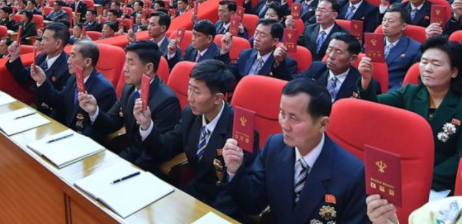

Тhe convenience of having many models is that you can put them in a situation not only one to decide whats the forecast, but all could have their contribution - namely voting classifier.

In [52]:
LR_l2_pipeline = Pipeline(LR_l2_pipe)
LR_l1_pipeline = Pipeline(LR_l1_pipe)
KN_pipeline = Pipeline(KN_pipe)
RN_pipeline = Pipeline(RN_pipe)
RF_pipeline = Pipeline(RF_pipe)
ET_pipeline = Pipeline(ET_pipe)
GNB_pipeline = Pipeline(GNB_pipe)
SV_pipeline = Pipeline(SV_pipe)

models_to_vote = [("LR_l2_vote", LR_l2_pipeline), ("LR_l1_vote", LR_l1_pipeline),
                  ("KN_vote", KN_pipeline), ("RN_vote", RN_pipeline), ("RF_vote", RF_pipeline),
                  ("ET_vote", ET_pipeline), ("GNB_vote", GNB_pipeline), ("SV_vote", SV_pipeline)]
VCL_hard = VotingClassifier(models_to_vote, voting = "hard")
VCL_soft = VotingClassifier(models_to_vote, voting = "soft")

              precision    recall  f1-score   support

           0       0.63      0.72      0.67       140
           1       0.39      0.25      0.31        72
           2       0.65      0.68      0.67        92

    accuracy                           0.60       304
   macro avg       0.56      0.55      0.55       304
weighted avg       0.58      0.60      0.58       304

Counts of real classes:      {0: 140, 1: 72, 2: 92}
Counts of predicted classes: {0: 161, 1: 46, 2: 97}


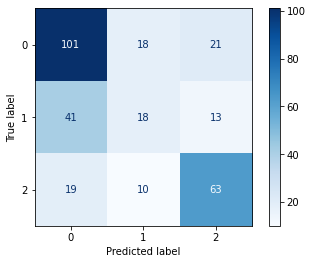

In [53]:
fit_predict_report(VCL_hard, X_hp_train, y_hp_train, X_hp_test, y_hp_test)

              precision    recall  f1-score   support

           0       0.65      0.76      0.70       140
           1       0.46      0.24      0.31        72
           2       0.63      0.72      0.67        92

    accuracy                           0.62       304
   macro avg       0.58      0.57      0.56       304
weighted avg       0.60      0.62      0.60       304

Counts of real classes:      {0: 140, 1: 72, 2: 92}
Counts of predicted classes: {0: 163, 1: 37, 2: 104}


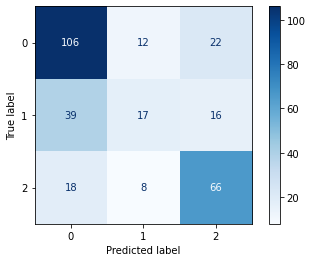

In [54]:
fit_predict_report(VCL_soft, X_hp_train, y_hp_train, X_hp_test, y_hp_test)

That didn't go very well too, but there's a one last trick we could use. VotingClassifier offers "weights" parameter where we can put weight of every classifier. Ideally this could have been a weights parameter for each class of every estimator.  

Bellow weights are kind of randomly chosen(they're not prepared in advance to make better results). Thes could be gridsearched also. There's a custom class called "VotingClassifierCV", curtesy of Avidale(https://github.com/avidale/sklearn_style/blob/master/estimators/voting_cv.py), which does that.


In [55]:
VCL_hard_weight_f1 = VotingClassifier(models_to_vote, voting = "hard", weights = [0.46, 0.25, 0.29, 0.46, 0.25, 0.29, 0.46, 0.25])
VCL_soft_weight_f1 = VotingClassifier(models_to_vote, voting = "soft", weights = [0.46, 0.25, 0.29, 0.46, 0.25, 0.29, 0.46, 0.25])

              precision    recall  f1-score   support

           0       0.65      0.67      0.66       140
           1       0.38      0.29      0.33        72
           2       0.65      0.73      0.69        92

    accuracy                           0.60       304
   macro avg       0.56      0.56      0.56       304
weighted avg       0.58      0.60      0.59       304

Counts of real classes:      {0: 140, 1: 72, 2: 92}
Counts of predicted classes: {0: 145, 1: 56, 2: 103}


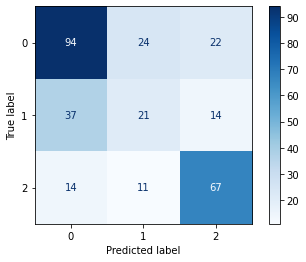

In [56]:
fit_predict_report(VCL_hard_weight_f1, X_hp_train, y_hp_train, X_hp_test, y_hp_test)

              precision    recall  f1-score   support

           0       0.64      0.74      0.68       140
           1       0.44      0.24      0.31        72
           2       0.64      0.72      0.68        92

    accuracy                           0.61       304
   macro avg       0.57      0.56      0.56       304
weighted avg       0.59      0.61      0.59       304

Counts of real classes:      {0: 140, 1: 72, 2: 92}
Counts of predicted classes: {0: 162, 1: 39, 2: 103}


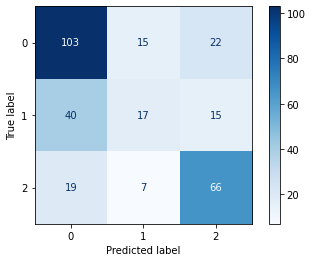

In [57]:
fit_predict_report(VCL_soft_weight_f1, X_hp_train, y_hp_train, X_hp_test, y_hp_test)

Even with arbitrary numbers we have better result already ... or maybe we did really beat the odds.

Articles: https://www.sbo.net/strategy/football-prediction-model-poisson-distribution/